In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# check content of drive
!ls "/content/drive/My Drive/Thesis Internal/Code"

 01_models_test_cases					  'old datasets used'
 audio_augmentation					   Pretagging
 Axl_Test						   resnet_testcases.gsheet
 binary_audio_cleaned_cropped				   Russel_Test
 binary_test_split_audio_Depression_AVEC2017_2		   test_binary_vandanaModel.ipynb
 binary_train_split_audio_Depression_AVEC2017_2		   test_customModel1.ipynb
'Copy of test_InceptionV3_model1 [ITO NA YUN AXL].ipynb'   test_inceptionV3_model1.ipynb
 dev_split_mfcc_augmented_Depression_AVEC2017_2		   test_InceptionV3_model1_V2.ipynb
 dev_split_mfcc_augmented_Depression_AVEC2017_2_VERSION2   test_predict
 Eli_Test						   test_split_audio_Depression_AVEC2017_2
 inceptionV3_model1_testcases.gsheet			   test_split_mfcc_Depression_AVEC2017_2
 model							   train_split_audio_Depression_AVEC2017_2
 model_tuning						   train_split_mfcc_Depression_AVEC2017_2


In [3]:
%matplotlib inline
from IPython import display
import os
import math
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import *
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
tf.random.set_seed(42)

## Importing and Splitting the dataset

In [4]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

data_dir = "/content/drive/My Drive/Thesis Internal/Code/train_split_mfcc_Depression_AVEC2017_2" #change_path
test_data_dir = "/content/drive/My Drive/Thesis Internal/Code/test_split_mfcc_Depression_AVEC2017_2" #change_path

aug_data_dir = "/content/drive/My Drive/Thesis Internal/Code/dev_split_mfcc_augmented_Depression_AVEC2017_2" #change_path

def image_generator(height, width):
    datagen = ImageDataGenerator(
        rescale=1./255.,
        validation_split=0.1, #to change split
    )

    test_datagen = ImageDataGenerator(
        rescale=1./255.
    )

    aug_datagen = ImageDataGenerator(
        rescale=1./255.
    )

    # Modify the flow_from_directory method to handle 5 classes
    train_ds = datagen.flow_from_directory(
        data_dir,
        batch_size=batch_size,
        subset="training",
        shuffle=True,
        class_mode='categorical', #changed
        target_size=(height, width),
        classes={'level_0': 0, 'level_1': 1, 'level_2': 2, 'level_3': 3, 'level_4': 4}
    )

    val_ds = datagen.flow_from_directory(
        data_dir,
        subset="validation",
        class_mode='categorical', #changed
        target_size=(height, width),
        batch_size=batch_size,
        classes={'level_0': 0, 'level_1': 1, 'level_2': 2, 'level_3': 3, 'level_4': 4}
    )

    test_ds = test_datagen.flow_from_directory(
        test_data_dir,
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical', #changed
        target_size=(height, width),
        classes={'level_0': 0, 'level_1': 1, 'level_2': 2, 'level_3': 3, 'level_4': 4}
    )

    aug_train_ds = aug_datagen.flow_from_directory(
        aug_data_dir,
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical', #changed
        target_size=(height, width),
        classes={'level_0': 0, 'level_1': 1, 'level_2': 2, 'level_3': 3, 'level_4': 4}
    )

    return train_ds, val_ds, test_ds, aug_train_ds

batch_size = 32  # add batch_size here or elsewhere in your code
height, width = 400, 1000  #change
train_ds, val_ds, test_ds, aug_train_ds = image_generator(height, width)

# Change your print statement to reflect the 5 classes
total_image = np.concatenate([train_ds.labels, val_ds.labels])
class_counts = {}
for i in range(5):
    class_name = f'level_{i}'
    class_counts[class_name] = len(np.where(total_image==i)[0])

print('\n\n', class_counts)


Found 130 images belonging to 5 classes.
Found 12 images belonging to 5 classes.
Found 47 images belonging to 5 classes.
Found 567 images belonging to 5 classes.


 {'level_0': 64, 'level_1': 35, 'level_2': 25, 'level_3': 13, 'level_4': 5}


## Visualizing the dataset

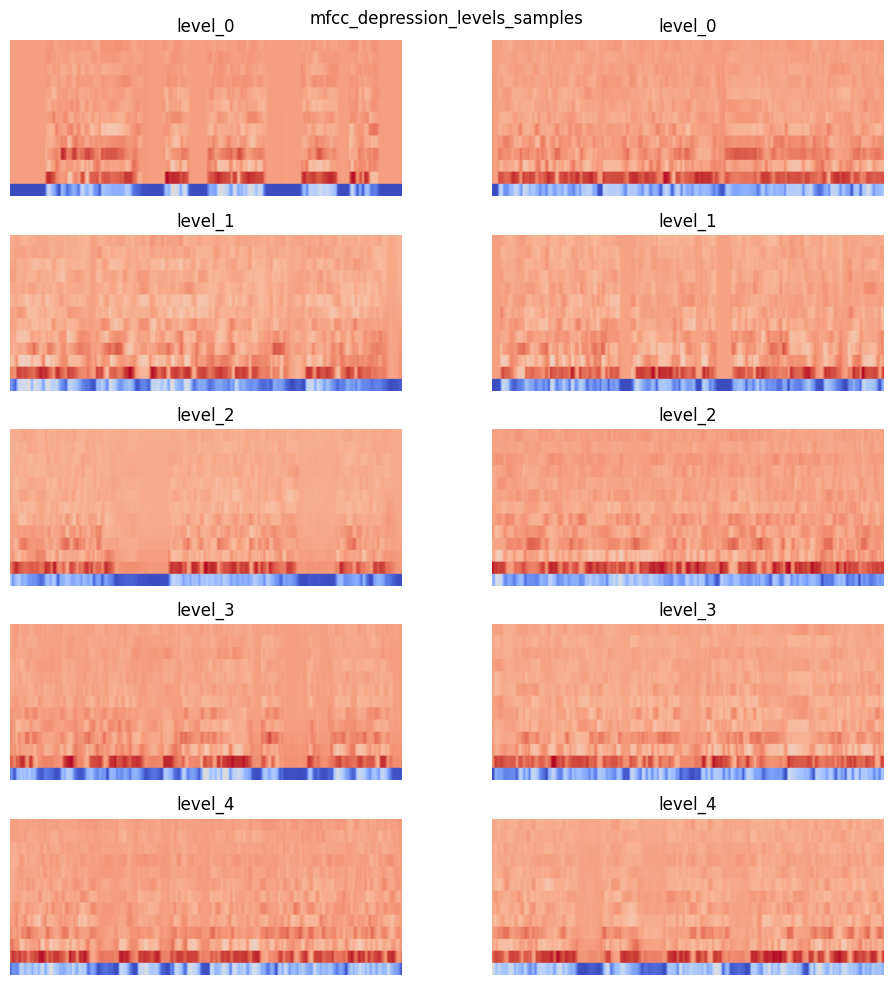

In [5]:
import matplotlib.pyplot as plt

# single_image_height = 4  # inches
# single_image_width = single_image_height * 2.5  # inches

# fig_width = 2 * single_image_width  # since there are 2 columns
# fig_height = 5 * single_image_height  # since there are 5 rows

# fig, ax = plt.subplots(5, 2, figsize=(fig_width, fig_height))
fig, ax = plt.subplots(5, 2, figsize=(10, 10))  # 5 levels x 2 samples
fig.suptitle("mfcc_depression_levels_samples")

class_dict = {v: k for k, v in train_ds.class_indices.items()}
samples_needed = {k: 2 for k in range(5)}
collected_samples = {k: [] for k in range(5)}

while any(v > 0 for v in samples_needed.values()):
    images, labels = train_ds.next()
    for image, label in zip(images, labels):
        label_index = np.argmax(label)
        if samples_needed[label_index] > 0:
            collected_samples[label_index].append(image)
            samples_needed[label_index] -= 1

# Plot the collected samples
for label_index, images_list in collected_samples.items():
    for i, image in enumerate(images_list):
        ax[label_index, i].imshow(image)
        ax[label_index, i].set_title(f'{class_dict[label_index]}')
        ax[label_index, i].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top space for the main title
plt.show()


## Visualizing the augmented dataset

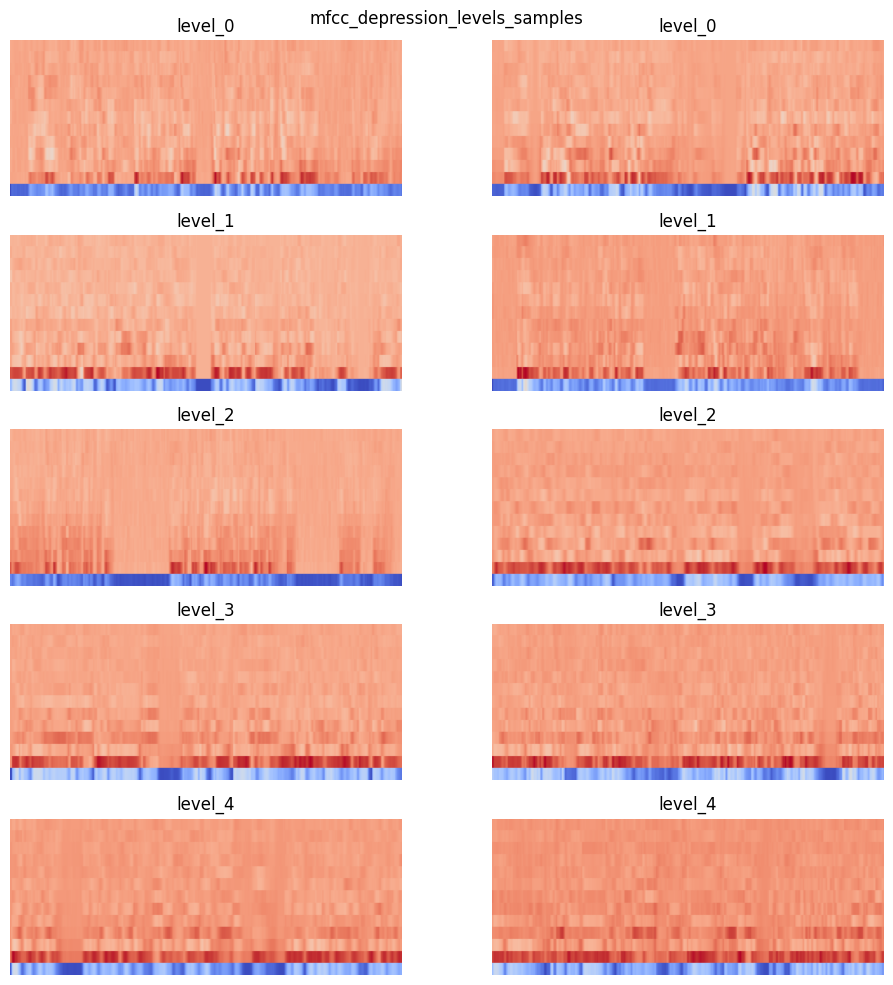

In [6]:
import matplotlib.pyplot as plt

# single_image_height = 4  # inches
# single_image_width = single_image_height * 2.5  # inches

# fig_width = 2 * single_image_width  # since there are 2 columns
# fig_height = 5 * single_image_height  # since there are 5 rows

# fig, ax = plt.subplots(5, 2, figsize=(fig_width, fig_height))
fig, ax = plt.subplots(5, 2, figsize=(10, 10))  # 5 levels x 2 samples
fig.suptitle("mfcc_depression_levels_samples")

class_dict = {v: k for k, v in aug_train_ds.class_indices.items()}
samples_needed = {k: 2 for k in range(5)}
collected_samples = {k: [] for k in range(5)}

while any(v > 0 for v in samples_needed.values()):
    images, labels = aug_train_ds.next()
    for image, label in zip(images, labels):
        label_index = np.argmax(label)
        if samples_needed[label_index] > 0:
            collected_samples[label_index].append(image)
            samples_needed[label_index] -= 1

# Plot the collected samples
for label_index, images_list in collected_samples.items():
    for i, image in enumerate(images_list):
        ax[label_index, i].imshow(image)
        ax[label_index, i].set_title(f'{class_dict[label_index]}')
        ax[label_index, i].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top space for the main title
plt.show()


# Applying Class Weights to address Imbalanced dataset

In [7]:
#adding class weights
from sklearn.utils.class_weight import compute_class_weight

# Assuming train_ds.classes provides the class indices of the training data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_ds.classes),
    y=train_ds.classes
)

# Turn class_weights into a dictionary to use it with Keras
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}


## To keep track of Time duration during training

In [8]:
import time

class TimingCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(TimingCallback, self).__init__()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.start_time
        self.epoch_times.append(elapsed_time)
        print(f"Epoch {epoch + 1}: {elapsed_time:.2f} seconds")

    def on_train_begin(self, logs=None):
        self.total_time = time.time()

    def on_train_end(self, logs=None):
        total_time_elapsed = time.time() - self.total_time
        avg_time_per_epoch = sum(self.epoch_times) / len(self.epoch_times)
        print(f"Total training time: {total_time_elapsed:.2f} seconds")
        print(f"Average time per epoch: {avg_time_per_epoch:.2f} seconds")


## Initial VGG16 + BiLSTM Model


In [9]:
import tensorflow as tf
from tensorflow.keras import layers

input_shape = (height, width, 3)

base_model_vgg16 = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model_vgg16.trainable = False

model = tf.keras.Sequential()
model.add(base_model_vgg16)
model.add(layers.Flatten())
model.add(layers.Reshape((1, -1)))  # Reshape for BiLSTM, adjust as needed
model.add(layers.Bidirectional(layers.LSTM(64)))  # BiLSTM layer
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(5, activation='softmax'))  # Assuming 5 classes

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 12, 31, 512)       14714688  
                                                                 
 flatten (Flatten)           (None, 190464)            0         
                                                                 
 reshape (Reshape)           (None, 1, 190464)         0         
                                                                 
 bidirectional (Bidirection  (None, 128)               97550848  
 al)                                                             
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

In [10]:
# Adjusting to monitor validation accuracy
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Thesis Internal/Code/model_tuning/vgg16_initial_hybrid5.h5', monitor='val_loss', verbose=1, mode='min', save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", restore_best_weights=True, patience=5)
time_callback = TimingCallback()
callbacks_list = [checkpoint, early, time_callback]
# callbacks_list = [checkpoint]

history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=100,
        shuffle=True,
        verbose=True,
        callbacks=callbacks_list,
        class_weight=class_weight_dict  # Pass class weights here
)

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 1.7103 - accuracy: 0.2846
Epoch 1: val_loss improved from inf to 1.79726, saving model to /content/drive/My Drive/Thesis Internal/Code/model_tuning/vgg16_initial_hybrid5.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1: 49.52 seconds
5/5 [==============================] - 50s 5s/step - loss: 1.7103 - accuracy: 0.2846 - val_loss: 1.7973 - val_accuracy: 0.1667
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 1.7365 - accuracy: 0.1769
Epoch 2: val_loss improved from 1.79726 to 1.74918, saving model to /content/drive/My Drive/Thesis Internal/Code/model_tuning/vgg16_initial_hybrid5.h5
Epoch 2: 9.96 seconds
5/5 [==============================] - 10s 2s/step - loss: 1.7365 - accuracy: 0.1769 - val_loss: 1.7492 - val_accuracy: 0.1667
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 1.6575 - accuracy: 0.1769
Epoch 3: val_loss improved from 1.74918 to 1.69942, saving model to /content/drive/My Drive/Thesis Internal/Code/model_tuning/vgg16_initial_hybrid5.h5
Epoch 3: 9.97 seconds
5/5 [==============================] - 10s 2s/step - loss: 1.6575 - accuracy: 0.1769 - val_loss: 1.6994 - val_accuracy: 0.1667
Epoch 4/100
5/5 [==============================] - ETA: 0s - los

## Evaluation of *Initial Model*

In [11]:
train_result = model.evaluate(train_ds)
val_result = model.evaluate(val_ds)
test_result = model.evaluate(test_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result,test_result),columns=['Train','Val','Test'],index=['Loss','Acc'])
no_augmented_df

2/2 [==============================] - 12s 11s/step - loss: 1.5854 - accuracy: 0.1277


,Train,Val,Test
Loss,1.580683,1.577489,1.585367
Acc,0.230769,0.166667,0.127660


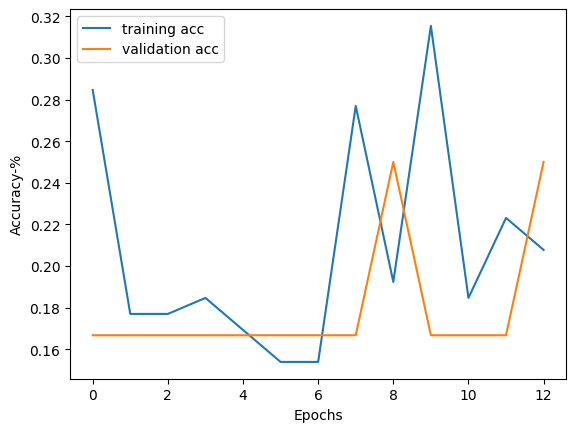

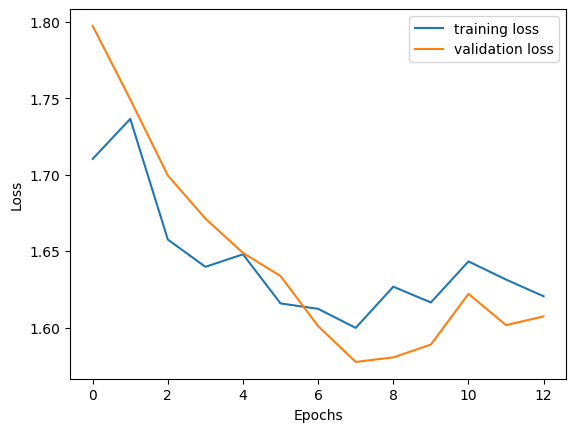

In [12]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [13]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Predict the classes and probabilities for the test dataset
test_pred_prob = model.predict(test_ds)
test_pred = np.argmax(test_pred_prob, axis=1)
test_true = test_ds.labels

# Determine the number of classes in the test dataset
n_classes = len(np.unique(test_true))

# 2. Compute the metrics for the test dataset

# Test metrics
test_precision = precision_score(test_true, test_pred, average='weighted', zero_division=1)
test_recall = recall_score(test_true, test_pred, average='weighted')
test_f1 = f1_score(test_true, test_pred, average='weighted')
test_conf_matrix = confusion_matrix(test_true, test_pred, labels=list(range(n_classes)))
test_true_onehot = np.eye(n_classes)[test_true]
test_roc_auc = roc_auc_score(test_true_onehot, test_pred_prob, multi_class='ovr')

# Create a dataframe to display the results for the test set
test_metrics_df = pd.DataFrame({
    'Test': [test_precision, test_recall, test_f1, test_roc_auc]
}, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

print("Test Metrics DataFrame:")
print(test_metrics_df)

print("\nTest Confusion Matrix:")
print(test_conf_matrix)


2/2 [==============================] - 3s 30ms/step
Test Metrics DataFrame:
               Test
Precision  0.437352
Recall     0.106383
F1 Score   0.021277
AUC        0.566351

Test Confusion Matrix:
[[ 0  0 22  0  0]
 [ 0  0 11  0  0]
 [ 0  0  5  0  0]
 [ 2  0  5  0  0]
 [ 0  0  2  0  0]]


In [14]:
# Assuming test_conf_matrix is already computed as shown in your code
n_classes = len(np.unique(test_true))  # Number of classes

# Initialize arrays to store TP, FP, FN, TN for each class
TP = np.zeros(n_classes)
FP = np.zeros(n_classes)
FN = np.zeros(n_classes)
TN = np.zeros(n_classes)

# Calculate TP, FP, FN, TN for each class
for i in range(n_classes):
    TP[i] = test_conf_matrix[i, i]
    FP[i] = test_conf_matrix[:, i].sum() - TP[i]
    FN[i] = test_conf_matrix[i, :].sum() - TP[i]
    TN[i] = test_conf_matrix.sum() - (FP[i] + FN[i] + TP[i])

print("Confusion Matrix Metrics by Class:")
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()

metrics_by_class = list(zip(TP_list, TN_list, FP_list, FN_list))

# Print the transposed lists
for i, class_metrics in enumerate(metrics_by_class):
    print(f"Class {i}: {class_metrics}")

Confusion Matrix Metrics by Class:
Class 0: (0.0, 23.0, 2.0, 22.0)
Class 1: (0.0, 36.0, 0.0, 11.0)
Class 2: (5.0, 2.0, 40.0, 0.0)
Class 3: (0.0, 40.0, 0.0, 7.0)
Class 4: (0.0, 45.0, 0.0, 2.0)


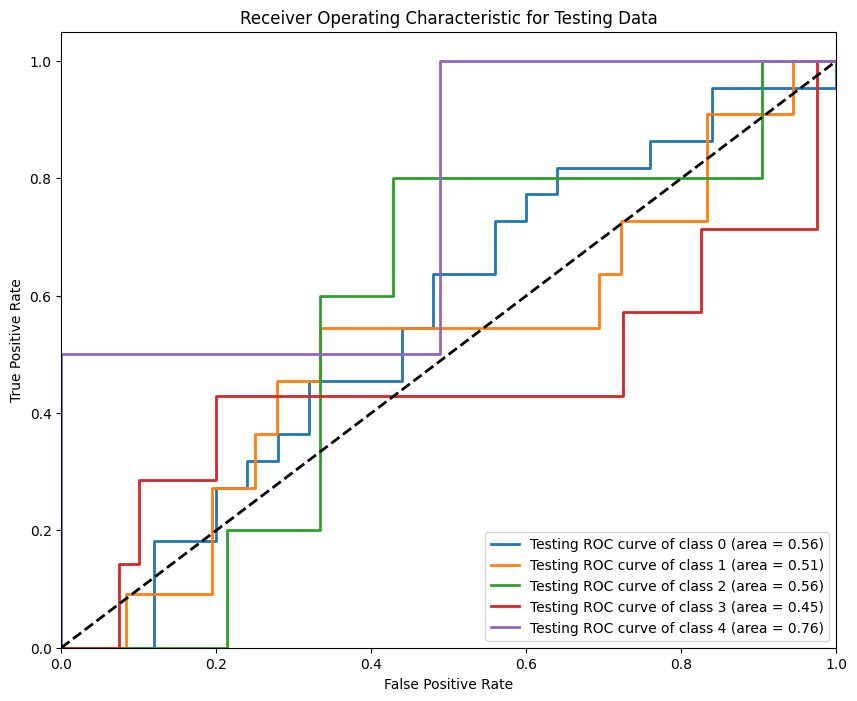

In [15]:
#Matrix Visualization
# Training AUC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_true_onehot[:, i], test_pred_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Testing ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc="lower right")
plt.show()

**TEST CASES INSERTION**

In [16]:
import gspread
from google.colab import auth
from google.auth import default
from gspread.utils import rowcol_to_a1

# Authenticate the user
auth.authenticate_user()

# Create a gspread client using the authenticated Google credentials
creds, _ = default()
gc = gspread.authorize(creds)

# Open a spreadsheet by its title or URL
spreadsheet = gc.open('vgg16_testcases')  # Replace with your spreadsheet name
sheet = spreadsheet.sheet1  # Access the first sheet

# Assuming that the TP_list, TN_list, FP_list, and FN_list have been calculated
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()
metrics_flat = [item for sublist in zip(TP_list, TN_list, FP_list, FN_list) for item in sublist]

# Data to append
data_to_append = [
    #ACCCURACY AND LOSS
    train_result[0],  # Training loss [B]
    train_result[1],  # Training accuracy [C]
    val_result[0],    # Validation loss [D]
    val_result[1],     # Validation accuracy [E]
    test_result[0],    # Testing loss [F]
    test_result[1],     # Testing accuracy [G]
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc
]

#Insertion
# Find the first empty row in column B
col_values = sheet.col_values(2)  # Column number for 'B' is 2
first_empty_row = len(col_values) + 1

# Calculate the range to update
start_cell = rowcol_to_a1(first_empty_row, 2)  # Start at column B
end_cell = rowcol_to_a1(first_empty_row, 1 + len(data_to_append))  # Adjust the end column based on data length
cell_range = f"{start_cell}:{end_cell}"

# Update the entire row at once
sheet.update(cell_range, [data_to_append])

#FOR CONFUSION MATRIX INSERTION
# Loop through the metrics_flat and update each cell
for index, value in enumerate(metrics_flat):
    # Calculate row and column offset
    row_offset = (index // 4) + first_empty_row
    col_offset = (index % 4) + 12

    # Convert to A1 notation and update the cell
    cell_range = rowcol_to_a1(first_empty_row, 12) + ':' + rowcol_to_a1(first_empty_row, 12 + len(metrics_flat) - 1)
    sheet.update(cell_range, [metrics_flat])

In [17]:
# Add a ReduceLROnPlateau callback to reduce the learning rate when the validation loss plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.000001, #to change reduce_lr
    verbose=1
)
callbacks_list = [checkpoint, early, time_callback, reduce_lr]

history = model.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=100,
        shuffle=True,
        verbose=True,
        callbacks=callbacks_list,
        class_weight=class_weight_dict  # Pass class weights here
        )


Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 1.6238 - accuracy: 0.2293
Epoch 1: val_loss did not improve from 1.57749
Epoch 1: 38.37 seconds
18/18 [==============================] - 38s 2s/step - loss: 1.6238 - accuracy: 0.2293 - val_loss: 1.5925 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 1.6283 - accuracy: 0.2293
Epoch 2: val_loss improved from 1.57749 to 1.56270, saving model to /content/drive/My Drive/Thesis Internal/Code/model_tuning/vgg16_initial_hybrid5.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2: 32.21 seconds
18/18 [==============================] - 32s 2s/step - loss: 1.6283 - accuracy: 0.2293 - val_loss: 1.5627 - val_accuracy: 0.0833 - lr: 1.0000e-04
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 1.6403 - accuracy: 0.1640
Epoch 3: val_loss did not improve from 1.56270
Epoch 3: 21.19 seconds
18/18 [==============================] - 21s 1s/step - loss: 1.6403 - accuracy: 0.1640 - val_loss: 1.6074 - val_accuracy: 0.0833 - lr: 1.0000e-04
Epoch 4/100
18/18 [==============================] - ETA: 0s - loss: 1.6194 - accuracy: 0.2011
Epoch 4: val_loss did not improve from 1.56270
Epoch 4: 22.56 seconds
18/18 [==============================] - 23s 1s/step - loss: 1.6194 - accuracy: 0.2011 - val_loss: 1.5712 - val_accuracy: 0.0833 - lr: 1.0000e-04
Epoch 5/100
18/18 [==============================] - ETA: 0s - loss: 1.5985 - accuracy: 0.1887
Epoch 5: val_loss did not improve from 1.56270
Epoch 5: 21.97 seconds
18/18 [==============================] - 22s

## Evaluation of *Initial Model* with **Augmentation**

In [18]:
train_result = model.evaluate(train_ds)
val_result = model.evaluate(val_ds)
test_result = model.evaluate(test_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result,test_result),columns=['Train','Val','Test'],index=['Loss','Acc'])
augmented_df

2/2 [==============================] - 2s 520ms/step - loss: 1.5621 - accuracy: 0.1489


,Train,Val,Test
Loss,1.566769,1.562702,1.562130
Acc,0.092308,0.083333,0.148936


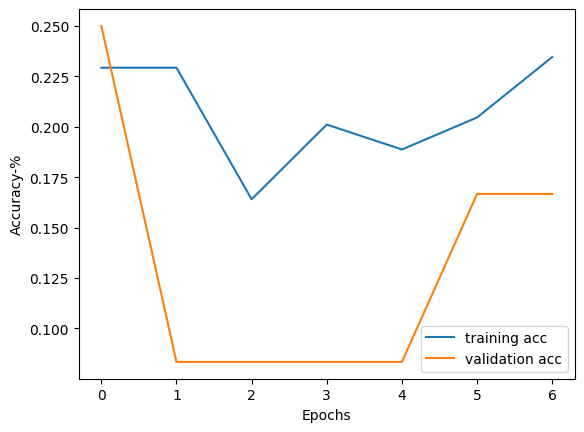

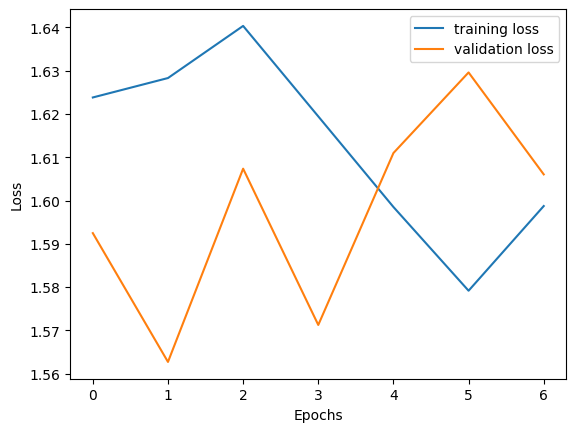

In [19]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [20]:
#METRICS
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Predict the classes and probabilities for the test dataset
test_pred_prob = model.predict(test_ds)
test_pred = np.argmax(test_pred_prob, axis=1)
test_true = test_ds.labels

# Determine the number of classes in the test dataset
n_classes = len(np.unique(test_true))

# 2. Compute the metrics for the test dataset

# Test metrics
test_precision = precision_score(test_true, test_pred, average='weighted', zero_division=1)
test_recall = recall_score(test_true, test_pred, average='weighted')
test_f1 = f1_score(test_true, test_pred, average='weighted')
test_conf_matrix = confusion_matrix(test_true, test_pred, labels=list(range(n_classes)))
test_true_onehot = np.eye(n_classes)[test_true]
test_roc_auc = roc_auc_score(test_true_onehot, test_pred_prob, multi_class='ovr')

# Create a dataframe to display the results for the test set
test_metrics_df = pd.DataFrame({
    'Test': [test_precision, test_recall, test_f1, test_roc_auc]
}, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

print("Test Metrics DataFrame:")
print(test_metrics_df)

print("\nTest Confusion Matrix:")
print(test_conf_matrix)


2/2 [==============================] - 2s 1s/step
Test Metrics DataFrame:
               Test
Precision  0.873246
Recall     0.148936
F1 Score   0.038613
AUC        0.508789

Test Confusion Matrix:
[[ 0  0  0 22  0]
 [ 0  0  0 11  0]
 [ 0  0  0  5  0]
 [ 0  0  0  7  0]
 [ 0  0  0  2  0]]


In [21]:
# Assuming test_conf_matrix is already computed as shown in your code
n_classes = len(np.unique(test_true))  # Number of classes

# Initialize arrays to store TP, FP, FN, TN for each class
TP = np.zeros(n_classes)
FP = np.zeros(n_classes)
FN = np.zeros(n_classes)
TN = np.zeros(n_classes)

# Calculate TP, FP, FN, TN for each class
for i in range(n_classes):
    TP[i] = test_conf_matrix[i, i]
    FP[i] = test_conf_matrix[:, i].sum() - TP[i]
    FN[i] = test_conf_matrix[i, :].sum() - TP[i]
    TN[i] = test_conf_matrix.sum() - (FP[i] + FN[i] + TP[i])

print("Confusion Matrix Metrics by Class:")
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()

metrics_by_class = list(zip(TP_list, TN_list, FP_list, FN_list))

# Print the transposed lists
for i, class_metrics in enumerate(metrics_by_class):
    print(f"Class {i}: {class_metrics}")

Confusion Matrix Metrics by Class:
Class 0: (0.0, 25.0, 0.0, 22.0)
Class 1: (0.0, 36.0, 0.0, 11.0)
Class 2: (0.0, 42.0, 0.0, 5.0)
Class 3: (7.0, 0.0, 40.0, 0.0)
Class 4: (0.0, 45.0, 0.0, 2.0)


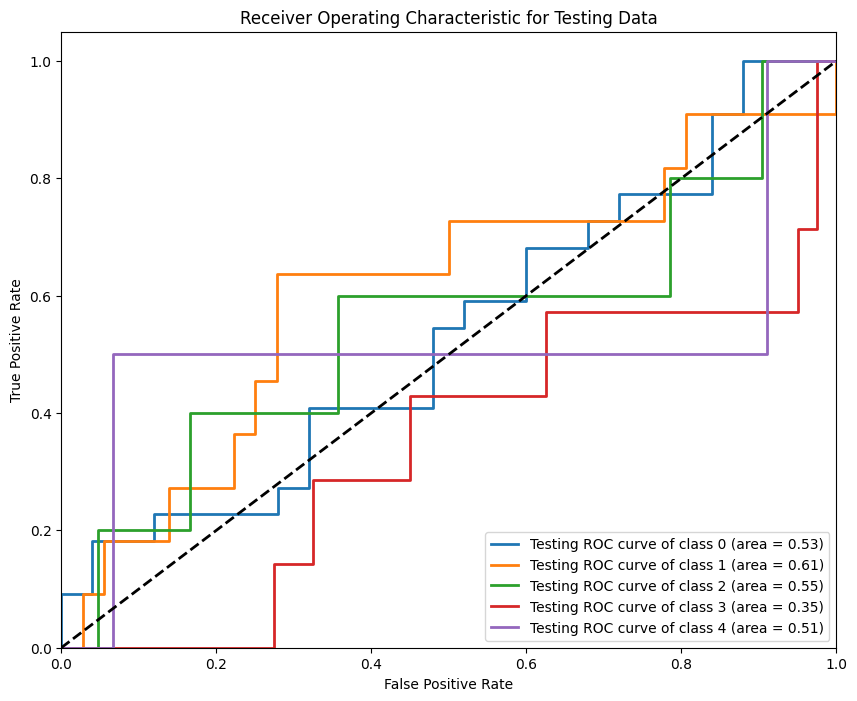

In [22]:
#Matrix Visualization
# Testing AUC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_true_onehot[:, i], test_pred_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Testing ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc="lower right")
plt.show()

In [23]:
#TEST CASES INSERTION

# Assuming that the TP_list, TN_list, FP_list, and FN_list have been calculated
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()
metrics_flat = [item for sublist in zip(TP_list, TN_list, FP_list, FN_list) for item in sublist]

# Data to append
data_to_append = [
    #ACCCURACY AND LOSS
    train_result[0],  # Training loss [B]
    train_result[1],  # Training accuracy [C]
    val_result[0],    # Validation loss [D]
    val_result[1],     # Validation accuracy [E]
    test_result[0],    # Testing loss [F]
    test_result[1],     # Testing accuracy [G]
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc
]

#Insertion
# Find the first empty row in column B
col_values = sheet.col_values(2)  # Column number for 'B' is 2
first_empty_row = len(col_values) + 1

# Calculate the range to update
start_cell = rowcol_to_a1(first_empty_row, 2)  # Start at column B
end_cell = rowcol_to_a1(first_empty_row, 1 + len(data_to_append))  # Adjust the end column based on data length
cell_range = f"{start_cell}:{end_cell}"

# Update the entire row at once
sheet.update(cell_range, [data_to_append])

#FOR CONFUSION MATRIX INSERTION
# Loop through the metrics_flat and update each cell
for index, value in enumerate(metrics_flat):
    # Calculate row and column offset
    row_offset = (index // 4) + first_empty_row
    col_offset = (index % 4) + 12

    # Convert to A1 notation and update the cell
    cell_range = rowcol_to_a1(first_empty_row, 12) + ':' + rowcol_to_a1(first_empty_row, 12 + len(metrics_flat) - 1)
    sheet.update(cell_range, [metrics_flat])

## Tuned VGG16 + BiLSTM Model

In [24]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2

tf.keras.backend.clear_session()

input_shape = (height, width, 3)  # Replace 'height' and 'width' with actual values

# Load the VGG16 model, pretrained on ImageNet
base_model_vgg16 = tf.keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

# Fine-tuning
base_model_vgg16.trainable = True
fine_tune_at = 15
for layer in base_model_vgg16.layers[:fine_tune_at]:
    layer.trainable = False

# Define the model
model_vgg16 = tf.keras.Sequential([
    base_model_vgg16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Reshape((1, -1)),  # Reshape for BiLSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),  # BiLSTM layer
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')  # Assuming 5 classes
])

# Compile the model
model_vgg16.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=['accuracy']
)

# Model summary
model_vgg16.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 12, 31, 512)       14714688  
                                                                 
 flatten (Flatten)           (None, 190464)            0         
                                                                 
 reshape (Reshape)           (None, 1, 190464)         0         
                                                                 
 bidirectional (Bidirection  (None, 128)               97550848  
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               3

In [25]:
# Adjusting to monitor validation accuracy
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Thesis Internal/Code/model_tuning/vgg16_tuned_hybridv5.h5', monitor='val_loss', verbose=1, mode='min', save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", restore_best_weights=True, patience=5)
time_callback = TimingCallback()
callbacks_list = [checkpoint, early, time_callback]

history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=100,
        shuffle=True,
        verbose=True,
        callbacks=callbacks_list,
        class_weight=class_weight_dict  # Pass class weights here
)


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 1.5828 - accuracy: 0.2385
Epoch 1: val_loss improved from inf to 1.56273, saving model to /content/drive/My Drive/Thesis Internal/Code/model_tuning/vgg16_tuned_hybridv5.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1: 11.18 seconds
5/5 [==============================] - 11s 2s/step - loss: 1.5828 - accuracy: 0.2385 - val_loss: 1.5627 - val_accuracy: 0.0833
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 1.5980 - accuracy: 0.3000
Epoch 2: val_loss improved from 1.56273 to 1.56252, saving model to /content/drive/My Drive/Thesis Internal/Code/model_tuning/vgg16_tuned_hybridv5.h5
Epoch 2: 9.98 seconds
5/5 [==============================] - 10s 2s/step - loss: 1.5980 - accuracy: 0.3000 - val_loss: 1.5625 - val_accuracy: 0.0833
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 1.5700 - accuracy: 0.2615
Epoch 3: val_loss improved from 1.56252 to 1.56119, saving model to /content/drive/My Drive/Thesis Internal/Code/model_tuning/vgg16_tuned_hybridv5.h5
Epoch 3: 10.03 seconds
5/5 [==============================] - 10s 2s/step - loss: 1.5700 - accuracy: 0.2615 - val_loss: 1.5612 - val_accuracy: 0.0833
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss

## Evaluation of *Tuned Model*

In [26]:
train_result = model.evaluate(train_ds)
val_result = model.evaluate(val_ds)
test_result = model.evaluate(test_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result,test_result),columns=['Train','Val','Test'],index=['Loss','Acc'])
no_augmented_df

2/2 [==============================] - 2s 505ms/step - loss: 1.5528 - accuracy: 0.1489


,Train,Val,Test
Loss,1.559344,1.556169,1.552808
Acc,0.092308,0.083333,0.148936


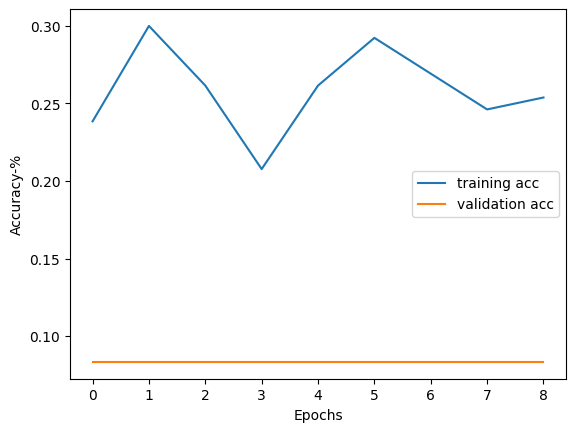

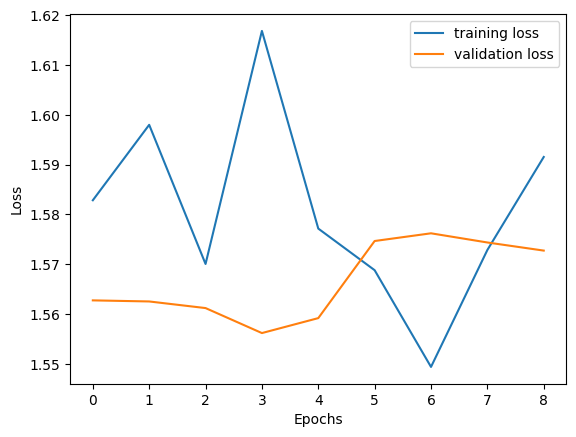

In [27]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [28]:
#METRICS
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Predict the classes and probabilities for the test dataset
test_pred_prob = model.predict(test_ds)
test_pred = np.argmax(test_pred_prob, axis=1)
test_true = test_ds.labels

# Determine the number of classes in the test dataset
n_classes = len(np.unique(test_true))

# 2. Compute the metrics for the test dataset

# Test metrics
test_precision = precision_score(test_true, test_pred, average='weighted', zero_division=1)
test_recall = recall_score(test_true, test_pred, average='weighted')
test_f1 = f1_score(test_true, test_pred, average='weighted')
test_conf_matrix = confusion_matrix(test_true, test_pred, labels=list(range(n_classes)))
test_true_onehot = np.eye(n_classes)[test_true]
test_roc_auc = roc_auc_score(test_true_onehot, test_pred_prob, multi_class='ovr')

# Create a dataframe to display the results for the test set
test_metrics_df = pd.DataFrame({
    'Test': [test_precision, test_recall, test_f1, test_roc_auc]
}, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

print("Test Metrics DataFrame:")
print(test_metrics_df)

print("\nTest Confusion Matrix:")
print(test_conf_matrix)


2/2 [==============================] - 2s 31ms/step
Test Metrics DataFrame:
               Test
Precision  0.873246
Recall     0.148936
F1 Score   0.038613
AUC        0.502548

Test Confusion Matrix:
[[ 0  0  0 22  0]
 [ 0  0  0 11  0]
 [ 0  0  0  5  0]
 [ 0  0  0  7  0]
 [ 0  0  0  2  0]]


In [29]:
# Assuming test_conf_matrix is already computed as shown in your code
n_classes = len(np.unique(test_true))  # Number of classes

# Initialize arrays to store TP, FP, FN, TN for each class
TP = np.zeros(n_classes)
FP = np.zeros(n_classes)
FN = np.zeros(n_classes)
TN = np.zeros(n_classes)

# Calculate TP, FP, FN, TN for each class
for i in range(n_classes):
    TP[i] = test_conf_matrix[i, i]
    FP[i] = test_conf_matrix[:, i].sum() - TP[i]
    FN[i] = test_conf_matrix[i, :].sum() - TP[i]
    TN[i] = test_conf_matrix.sum() - (FP[i] + FN[i] + TP[i])

print("Confusion Matrix Metrics by Class:")
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()

metrics_by_class = list(zip(TP_list, TN_list, FP_list, FN_list))

# Print the transposed lists
for i, class_metrics in enumerate(metrics_by_class):
    print(f"Class {i}: {class_metrics}")

Confusion Matrix Metrics by Class:
Class 0: (0.0, 25.0, 0.0, 22.0)
Class 1: (0.0, 36.0, 0.0, 11.0)
Class 2: (0.0, 42.0, 0.0, 5.0)
Class 3: (7.0, 0.0, 40.0, 0.0)
Class 4: (0.0, 45.0, 0.0, 2.0)


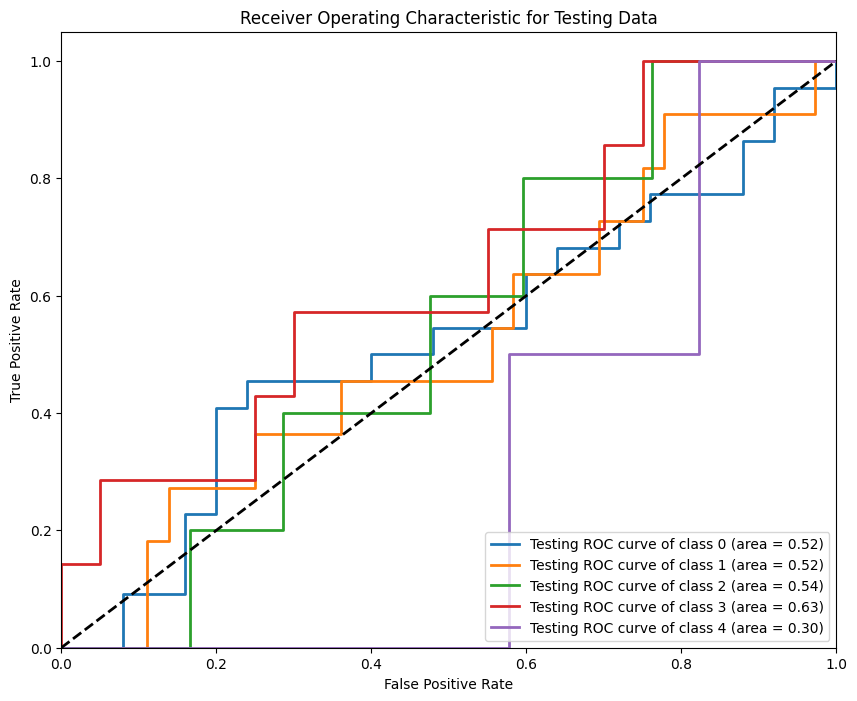

In [30]:
#Matrix Visualization
# Training AUC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_true_onehot[:, i], test_pred_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Testing ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc="lower right")
plt.show()

In [31]:
#TEST CASES INSERTION

# Assuming that the TP_list, TN_list, FP_list, and FN_list have been calculated
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()
metrics_flat = [item for sublist in zip(TP_list, TN_list, FP_list, FN_list) for item in sublist]

# Data to append
data_to_append = [
    #ACCCURACY AND LOSS
    train_result[0],  # Training loss [B]
    train_result[1],  # Training accuracy [C]
    val_result[0],    # Validation loss [D]
    val_result[1],     # Validation accuracy [E]
    test_result[0],    # Testing loss [F]
    test_result[1],     # Testing accuracy [G]
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc
]

#Insertion
# Find the first empty row in column B
col_values = sheet.col_values(2)  # Column number for 'B' is 2
first_empty_row = len(col_values) + 1

# Calculate the range to update
start_cell = rowcol_to_a1(first_empty_row, 2)  # Start at column B
end_cell = rowcol_to_a1(first_empty_row, 1 + len(data_to_append))  # Adjust the end column based on data length
cell_range = f"{start_cell}:{end_cell}"

# Update the entire row at once
sheet.update(cell_range, [data_to_append])

#FOR CONFUSION MATRIX INSERTION
# Loop through the metrics_flat and update each cell
for index, value in enumerate(metrics_flat):
    # Calculate row and column offset
    row_offset = (index // 4) + first_empty_row
    col_offset = (index % 4) + 12

    # Convert to A1 notation and update the cell
    cell_range = rowcol_to_a1(first_empty_row, 12) + ':' + rowcol_to_a1(first_empty_row, 12 + len(metrics_flat) - 1)
    sheet.update(cell_range, [metrics_flat])

In [32]:
# Add a ReduceLROnPlateau callback to reduce the learning rate when the validation loss plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.000001, #to change reduce_lr
    verbose=1
)
callbacks_list = [checkpoint, early, time_callback, reduce_lr]

history = model.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=100,
        shuffle=True,
        verbose=True,
        callbacks=callbacks_list,
        class_weight=class_weight_dict  # Pass class weights here
        )


Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 1.6086 - accuracy: 0.2787
Epoch 1: val_loss did not improve from 1.55617
Epoch 1: 22.63 seconds
18/18 [==============================] - 23s 1s/step - loss: 1.6086 - accuracy: 0.2787 - val_loss: 1.5735 - val_accuracy: 0.0833 - lr: 2.0000e-05
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 1.6251 - accuracy: 0.2363
Epoch 2: val_loss did not improve from 1.55617
Epoch 2: 22.47 seconds
18/18 [==============================] - 22s 1s/step - loss: 1.6251 - accuracy: 0.2363 - val_loss: 1.5767 - val_accuracy: 0.0833 - lr: 2.0000e-05
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 1.6096 - accuracy: 0.1958
Epoch 3: val_loss did not improve from 1.55617
Epoch 3: 21.77 seconds
18/18 [==============================] - 22s 1s/step - loss: 1.6096 - accuracy: 0.1958 - val_loss: 1.5833 - val_accuracy: 0.0833 - lr: 2.0000e-05
Epoch 4/100
18/18 [==============================] - ETA: 0s - loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 7: 31.51 seconds
18/18 [==============================] - 32s 2s/step - loss: 1.5829 - accuracy: 0.2310 - val_loss: 1.5479 - val_accuracy: 0.4167 - lr: 2.0000e-05
Epoch 8/100
18/18 [==============================] - ETA: 0s - loss: 1.5757 - accuracy: 0.2892
Epoch 8: val_loss did not improve from 1.54790
Epoch 8: 21.55 seconds
18/18 [==============================] - 22s 1s/step - loss: 1.5757 - accuracy: 0.2892 - val_loss: 1.5502 - val_accuracy: 0.2500 - lr: 2.0000e-05
Epoch 9/100
18/18 [==============================] - ETA: 0s - loss: 1.5532 - accuracy: 0.3228
Epoch 9: val_loss improved from 1.54790 to 1.52963, saving model to /content/drive/My Drive/Thesis Internal/Code/model_tuning/vgg16_tuned_hybridv5.h5
Epoch 9: 31.98 seconds
18/18 [==============================] - 32s 2s/step - loss: 1.5532 - accuracy: 0.3228 - val_loss: 1.5296 - val_accuracy: 0.4167 - lr: 2.0000e-05
Epoch 10/100
18/18 [==============================] - ETA: 0s - loss: 1.5578 - accuracy: 0.3192
Epoch 10: 

## Evaluation of *Tuned Model* with **Augmentation**

In [33]:
train_result = model.evaluate(train_ds)
val_result = model.evaluate(val_ds)
test_result = model.evaluate(test_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result,test_result),columns=['Train','Val','Test'],index=['Loss','Acc'])
augmented_df

2/2 [==============================] - 2s 510ms/step - loss: 0.6960 - accuracy: 0.9362


,Train,Val,Test
Loss,0.683038,0.744189,0.695954
Acc,0.976923,1.000000,0.936170


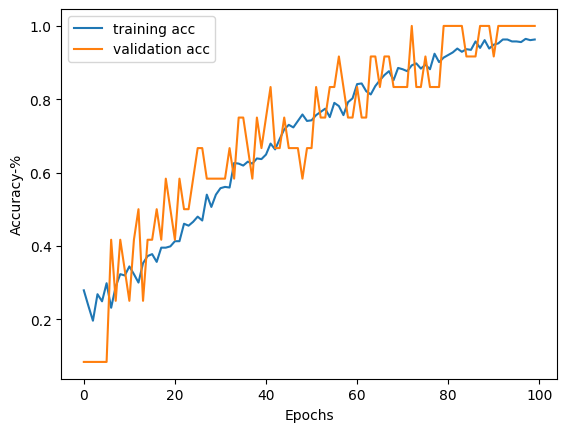

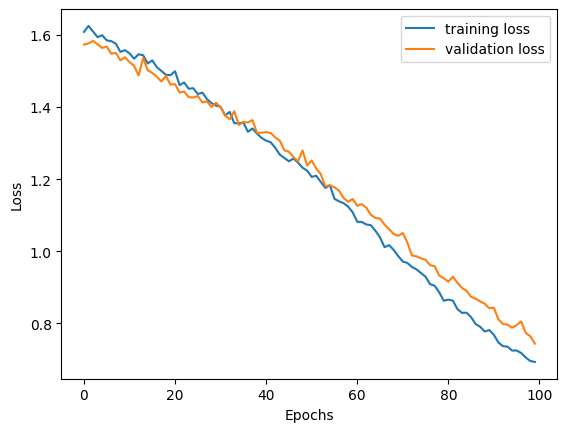

In [34]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [35]:
#METRICS
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Predict the classes and probabilities for the test dataset
test_pred_prob = model.predict(test_ds)
test_pred = np.argmax(test_pred_prob, axis=1)
test_true = test_ds.labels

# Determine the number of classes in the test dataset
n_classes = len(np.unique(test_true))

# 2. Compute the metrics for the test dataset

# Test metrics
test_precision = precision_score(test_true, test_pred, average='weighted', zero_division=1)
test_recall = recall_score(test_true, test_pred, average='weighted')
test_f1 = f1_score(test_true, test_pred, average='weighted')
test_conf_matrix = confusion_matrix(test_true, test_pred, labels=list(range(n_classes)))
test_true_onehot = np.eye(n_classes)[test_true]
test_roc_auc = roc_auc_score(test_true_onehot, test_pred_prob, multi_class='ovr')

# Create a dataframe to display the results for the test set
test_metrics_df = pd.DataFrame({
    'Test': [test_precision, test_recall, test_f1, test_roc_auc]
}, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

print("Test Metrics DataFrame:")
print(test_metrics_df)

print("\nTest Confusion Matrix:")
print(test_conf_matrix)


2/2 [==============================] - 2s 1s/step
Test Metrics DataFrame:
               Test
Precision  0.323007
Recall     0.319149
F1 Score   0.320414
AUC        0.482414

Test Confusion Matrix:
[[10  5  4  2  1]
 [ 4  3  0  3  1]
 [ 3  1  1  0  0]
 [ 3  3  0  1  0]
 [ 1  1  0  0  0]]


In [36]:
# Assuming test_conf_matrix is already computed as shown in your code
n_classes = len(np.unique(test_true))  # Number of classes

# Initialize arrays to store TP, FP, FN, TN for each class
TP = np.zeros(n_classes)
FP = np.zeros(n_classes)
FN = np.zeros(n_classes)
TN = np.zeros(n_classes)

# Calculate TP, FP, FN, TN for each class
for i in range(n_classes):
    TP[i] = test_conf_matrix[i, i]
    FP[i] = test_conf_matrix[:, i].sum() - TP[i]
    FN[i] = test_conf_matrix[i, :].sum() - TP[i]
    TN[i] = test_conf_matrix.sum() - (FP[i] + FN[i] + TP[i])

print("Confusion Matrix Metrics by Class:")
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()

metrics_by_class = list(zip(TP_list, TN_list, FP_list, FN_list))

# Print the transposed lists
for i, class_metrics in enumerate(metrics_by_class):
    print(f"Class {i}: {class_metrics}")

Confusion Matrix Metrics by Class:
Class 0: (10.0, 14.0, 11.0, 12.0)
Class 1: (3.0, 26.0, 10.0, 8.0)
Class 2: (1.0, 38.0, 4.0, 4.0)
Class 3: (1.0, 35.0, 5.0, 6.0)
Class 4: (0.0, 43.0, 2.0, 2.0)


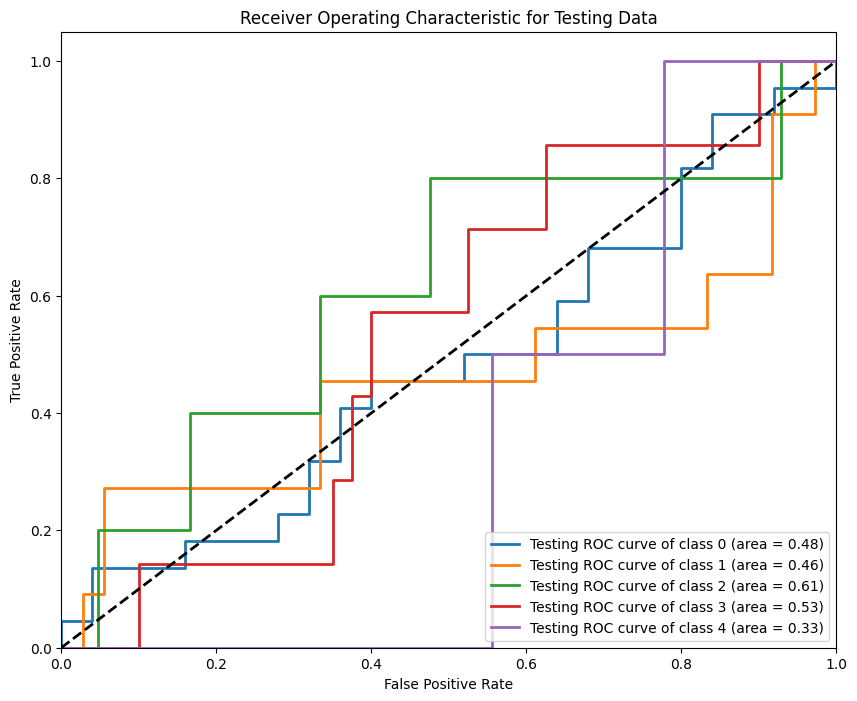

In [37]:
#Matrix Visualization
# Training AUC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_true_onehot[:, i], test_pred_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Testing ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc="lower right")
plt.show()

In [38]:
#TEST CASES INSERTION

# Assuming that the TP_list, TN_list, FP_list, and FN_list have been calculated
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()
metrics_flat = [item for sublist in zip(TP_list, TN_list, FP_list, FN_list) for item in sublist]

# Data to append
data_to_append = [
    #ACCCURACY AND LOSS
    train_result[0],  # Training loss [B]
    train_result[1],  # Training accuracy [C]
    val_result[0],    # Validation loss [D]
    val_result[1],     # Validation accuracy [E]
    test_result[0],    # Testing loss [F]
    test_result[1],     # Testing accuracy [G]
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc
]

#Insertion
# Find the first empty row in column B
col_values = sheet.col_values(2)  # Column number for 'B' is 2
first_empty_row = len(col_values) + 1

# Calculate the range to update
start_cell = rowcol_to_a1(first_empty_row, 2)  # Start at column B
end_cell = rowcol_to_a1(first_empty_row, 1 + len(data_to_append))  # Adjust the end column based on data length
cell_range = f"{start_cell}:{end_cell}"

# Update the entire row at once
sheet.update(cell_range, [data_to_append])

#FOR CONFUSION MATRIX INSERTION
# Loop through the metrics_flat and update each cell
for index, value in enumerate(metrics_flat):
    # Calculate row and column offset
    row_offset = (index // 4) + first_empty_row
    col_offset = (index % 4) + 12

    # Convert to A1 notation and update the cell
    cell_range = rowcol_to_a1(first_empty_row, 12) + ':' + rowcol_to_a1(first_empty_row, 12 + len(metrics_flat) - 1)
    sheet.update(cell_range, [metrics_flat])

## Metrics of Final Model

In [39]:
# # plot learning curve
# def plot_learning_curve(history):
#     acc = history.history['acc']
#     val_acc = history.history['val_acc']
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     epochs = range(len(acc))

#     plt.plot(epochs, acc, label='training acc')
#     plt.plot(epochs, val_acc, label='validation acc')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy-%')
#     plt.legend()
#     plt.figure()

#     plt.plot(epochs, loss, label='training loss')
#     plt.plot(epochs, val_loss, label='validation loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

# plot_learning_curve(history)

In [40]:
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
# import matplotlib.pyplot as plt

# # 1. Predict the classes and probabilities for the training and validation datasets
# train_pred_prob = model_inceptionv3.predict(train_ds)
# train_pred = np.argmax(train_pred_prob, axis=1)
# train_true = train_ds.labels

# val_pred_prob = model_inceptionv3.predict(val_ds)
# val_pred = np.argmax(val_pred_prob, axis=1)
# val_true = val_ds.labels

# n_classes = len(np.unique(train_true))

# # 2. Compute the metrics for both training and validation datasets

# # Training metrics
# train_precision = precision_score(train_true, train_pred, average='weighted', zero_division=1)
# # train_precision = precision_score(train_true, train_pred, average='weighted')
# train_recall = recall_score(train_true, train_pred, average='weighted')
# train_f1 = f1_score(train_true, train_pred, average='weighted')
# train_conf_matrix = confusion_matrix(train_true, train_pred)
# train_true_onehot = np.eye(n_classes)[train_true]
# train_roc_auc = roc_auc_score(train_true_onehot, train_pred_prob, multi_class='ovr')

# # Validation metrics
# val_precision = precision_score(val_true, val_pred, average='weighted', zero_division=1)
# # val_precision = precision_score(val_true, val_pred, average='weighted')
# val_recall = recall_score(val_true, val_pred, average='weighted')
# val_f1 = f1_score(val_true, val_pred, average='weighted')
# val_conf_matrix = confusion_matrix(val_true, val_pred)
# val_true_onehot = np.eye(n_classes)[val_true]
# val_roc_auc = roc_auc_score(val_true_onehot, val_pred_prob, multi_class='ovr')

# # Create a dataframe to display the results
# metrics_df = pd.DataFrame({
#     'Train': [train_precision, train_recall, train_f1, train_roc_auc],
#     'Val': [val_precision, val_recall, val_f1, val_roc_auc]
# }, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

# print("Metrics DataFrame:")
# print(metrics_df)

# print("\nTraining Confusion Matrix:")
# print(train_conf_matrix)

# print("\nValidation Confusion Matrix:")
# print(val_conf_matrix)


In [41]:
# # Training AUC curve
# plt.figure(figsize=(10, 8))
# for i in range(n_classes):
#     fpr, tpr, _ = roc_curve(train_true_onehot[:, i], train_pred_prob[:, i])
#     plt.plot(fpr, tpr, lw=2, label=f'Training ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
# plt.plot([0, 1], [0, 1], 'k--', lw=2)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic for Training Data')
# plt.legend(loc="lower right")
# plt.show()

# # Validation AUC curve
# plt.figure(figsize=(10, 8))
# for i in range(n_classes):
#     fpr, tpr, _ = roc_curve(val_true_onehot[:, i], val_pred_prob[:, i])
#     plt.plot(fpr, tpr, lw=2, linestyle='--', label=f'Validation ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
# plt.plot([0, 1], [0, 1], 'k--', lw=2)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic for Validation Data')
# plt.legend(loc="lower right")
# plt.show()
